# The Income Fluctuation Problem - Basic Model

In [1]:
import numpy as np
from quantecon.optimize import brent_max, brentq
from interpolation import interp
from numba import njit, float64, jitclass
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon import MarkovChain

C:\Users\Diogo\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
ifp_data = [
    ('R', float64),              # Interest rate 1 + r
    ('β', float64),              # Discount factor
    ('γ', float64),              # Preference parameter
    ('P', float64[:, :]),        # Markov matrix for binary Z_t
    ('y', float64[:]),           # Income is Y_t = y[Z_t]
    ('asset_grid', float64[:])   # Grid (array)
]

@jitclass(ifp_data)
class IFP:

    def __init__(self,
                 r=0.01,
                 β=0.96,
                 γ=1.5,
                 P=((0.6, 0.4),
                    (0.05, 0.95)),
                 y=(0.0, 2.0),
                 grid_max=16,
                 grid_size=50):

        self.R = 1 + r
        self.β, self.γ = β, γ
        self.P, self.y = np.array(P), np.array(y)
        self.asset_grid = np.linspace(0, grid_max, grid_size)

        # Recall that we need R β < 1 for convergence.
        assert self.R * self.β < 1, "Stability condition violated."

    def u_prime(self, c):
        return c**(-self.γ)

C:\Users\Diogo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  # Remove the CWD from sys.path while we load stuff.


In [3]:
@njit
def euler_diff(c, a, z, σ_vals, ifp):
    """
    The difference between the left- and right-hand side
    of the Euler Equation, given current policy σ.

        * c is the consumption choice
        * (a, z) is the state, with z in {0, 1}
        * σ_vals is a policy represented as a matrix.
        * ifp is an instance of IFP

    """

    # Simplify names
    R, P, y, β, γ  = ifp.R, ifp.P, ifp.y, ifp.β, ifp.γ
    asset_grid, u_prime = ifp.asset_grid, ifp.u_prime
    n = len(P)

    # Convert policy into a function by linear interpolation
    def σ(a, z):
        return interp(asset_grid, σ_vals[:, z], a)

    # Calculate the expectation conditional on current z
    expect = 0.0
    for z_hat in range(n):
        expect += u_prime(σ(R * (a - c) + y[z_hat], z_hat)) * P[z, z_hat]

    return u_prime(c) - max(β * R * expect, u_prime(a))

In [4]:
@njit
def K(σ, ifp):
    """
    The operator K.

    """
    σ_new = np.empty_like(σ)
    for i, a in enumerate(ifp.asset_grid):
        for z in (0, 1):
            result = brentq(euler_diff, 1e-8, a, args=(a, z, σ, ifp))
            σ_new[i, z] = result.root

    return σ_new

In [5]:
def solve_model_time_iter(model,    # Class with model information
                          σ,        # Initial condition
                          tol=1e-4,
                          max_iter=1000,
                          verbose=True,
                          print_skip=25):

    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        σ_new = K(σ, model)
        error = np.max(np.abs(σ - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        σ = σ_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return σ_new

In [6]:
ifp = IFP()

# Set up initial consumption policy of consuming all assets at all z
z_size = len(ifp.P)
a_grid = ifp.asset_grid
a_size = len(a_grid)
σ_init = np.repeat(a_grid.reshape(a_size, 1), z_size, axis=1)

σ_star = solve_model_time_iter(ifp, σ_init)

Error at iteration 25 is 0.011629589188248524.
Error at iteration 50 is 0.00038571830994538203.

Converged in 60 iterations.


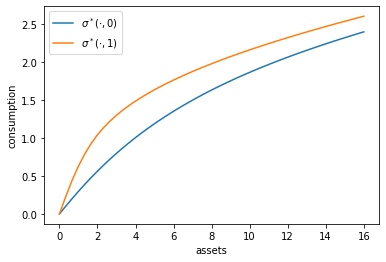

In [7]:
fig, ax = plt.subplots()
for z in range(z_size):
    label = rf'$\sigma^*(\cdot, {z})$'
    ax.plot(a_grid, σ_star[:, z], label=label)
ax.set(xlabel='assets', ylabel='consumption')
ax.legend()
plt.show()

In [8]:
def c_star(x, β, γ):

    return (1 - β ** (1/γ)) * x


def v_star(x, β, γ):

    return (1 - β**(1 / γ))**(-γ) * (x**(1-γ) / (1-γ))

Error at iteration 25 is 0.023332272630545492.
Error at iteration 50 is 0.005301238424249455.
Error at iteration 75 is 0.0019706324625650695.
Error at iteration 100 is 0.0008675521337956349.
Error at iteration 125 is 0.00041073542212255454.
Error at iteration 150 is 0.00020120334010526042.
Error at iteration 175 is 0.00010021430795065234.

Converged in 176 iterations.


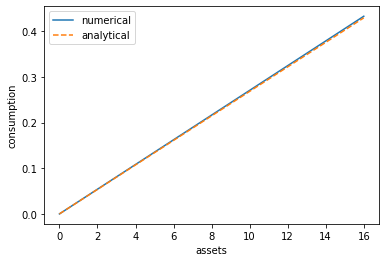

In [9]:
ifp_cake_eating = IFP(r=0.0, y=(0.0, 0.0))

σ_star = solve_model_time_iter(ifp_cake_eating, σ_init)

fig, ax = plt.subplots()
ax.plot(a_grid, σ_star[:, 0], label='numerical')
ax.plot(a_grid, c_star(a_grid, ifp.β, ifp.γ), '--', label='analytical')

ax.set(xlabel='assets', ylabel='consumption')
ax.legend()

plt.show()

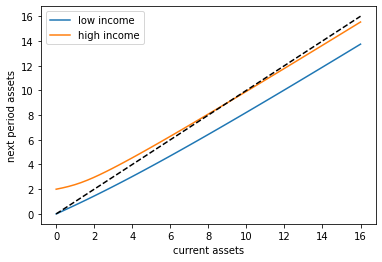

In [10]:
ifp = IFP()

σ_star = solve_model_time_iter(ifp, σ_init, verbose=False)
a = ifp.asset_grid
R, y = ifp.R, ifp.y

fig, ax = plt.subplots()
for z, lb in zip((0, 1), ('low income', 'high income')):
    ax.plot(a, R * (a - σ_star[:, z]) + y[z] , label=lb)

ax.plot(a, a, 'k--')
ax.set(xlabel='current assets', ylabel='next period assets')

ax.legend()
plt.show()

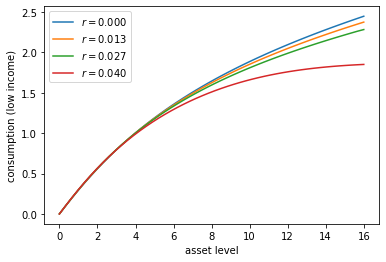

In [11]:
r_vals = np.linspace(0, 0.04, 4)

fig, ax = plt.subplots()
for r_val in r_vals:
    ifp = IFP(r=r_val)
    σ_star = solve_model_time_iter(ifp, σ_init, verbose=False)
    ax.plot(ifp.asset_grid, σ_star[:, 0], label=f'$r = {r_val:.3f}$')

ax.set(xlabel='asset level', ylabel='consumption (low income)')
ax.legend()
plt.show()

In [12]:
def compute_asset_series(ifp, T=500_000, seed=1234):
    """
    Simulates a time series of length T for assets, given optimal
    savings behavior.

    ifp is an instance of IFP
    """
    P, y, R = ifp.P, ifp.y, ifp.R  # Simplify names

    # Solve for the optimal policy
    σ_star = solve_model_time_iter(ifp, σ_init, verbose=False)
    σ = lambda a, z: interp(ifp.asset_grid, σ_star[:, z], a)

    # Simulate the exogeneous state process
    mc = MarkovChain(P)
    z_seq = mc.simulate(T, random_state=seed)

    # Simulate the asset path
    a = np.zeros(T+1)
    for t in range(T):
        z = z_seq[t]
        a[t+1] = R * (a[t] - σ(a[t], z)) + y[z]
    return a

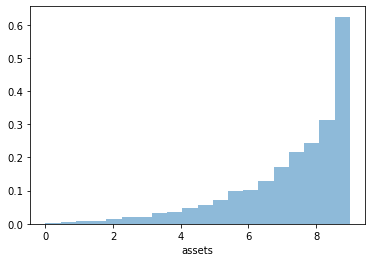

In [13]:
ifp = IFP()
a = compute_asset_series(ifp)

fig, ax = plt.subplots()
ax.hist(a, bins=20, alpha=0.5, density=True)
ax.set(xlabel='assets')
plt.show()

Solving model at r = 0.0
Solving model at r = 0.0008333333333333334
Solving model at r = 0.0016666666666666668
Solving model at r = 0.0025
Solving model at r = 0.0033333333333333335
Solving model at r = 0.004166666666666667
Solving model at r = 0.005
Solving model at r = 0.005833333333333334
Solving model at r = 0.006666666666666667
Solving model at r = 0.007500000000000001
Solving model at r = 0.008333333333333333
Solving model at r = 0.009166666666666667
Solving model at r = 0.01
Solving model at r = 0.010833333333333334
Solving model at r = 0.011666666666666667
Solving model at r = 0.0125
Solving model at r = 0.013333333333333334
Solving model at r = 0.014166666666666668
Solving model at r = 0.015000000000000001
Solving model at r = 0.015833333333333335
Solving model at r = 0.016666666666666666
Solving model at r = 0.0175
Solving model at r = 0.018333333333333333
Solving model at r = 0.01916666666666667
Solving model at r = 0.02


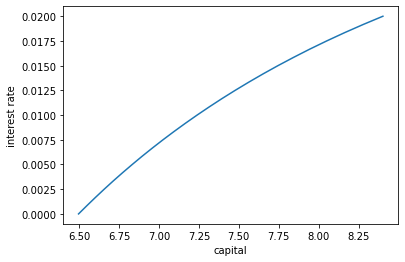

In [14]:
M = 25
r_vals = np.linspace(0, 0.02, M)
fig, ax = plt.subplots()

asset_mean = []
for r in r_vals:
    print(f'Solving model at r = {r}')
    ifp = IFP(r=r)
    mean = np.mean(compute_asset_series(ifp, T=250_000))
    asset_mean.append(mean)
ax.plot(asset_mean, r_vals)

ax.set(xlabel='capital', ylabel='interest rate')

plt.show()